Model: Model(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=6, bias=True)
  (fc4): Linear(in_features=6, out_features=12, bias=True)
  (fc5): Linear(in_features=12, out_features=1, bias=True)
)
Total parameters: 199


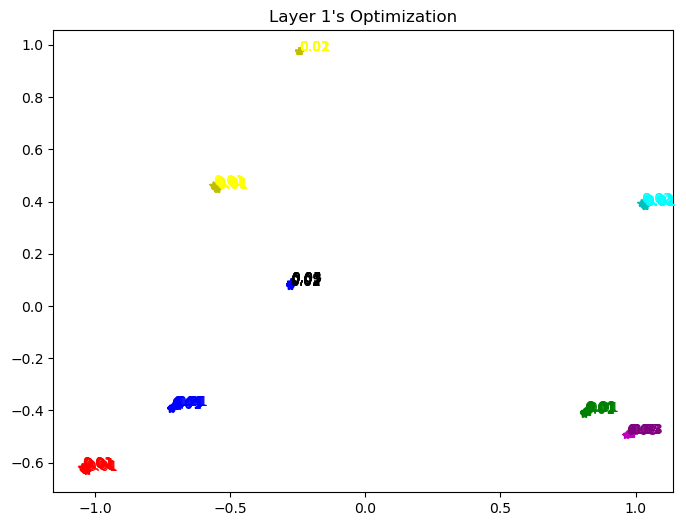

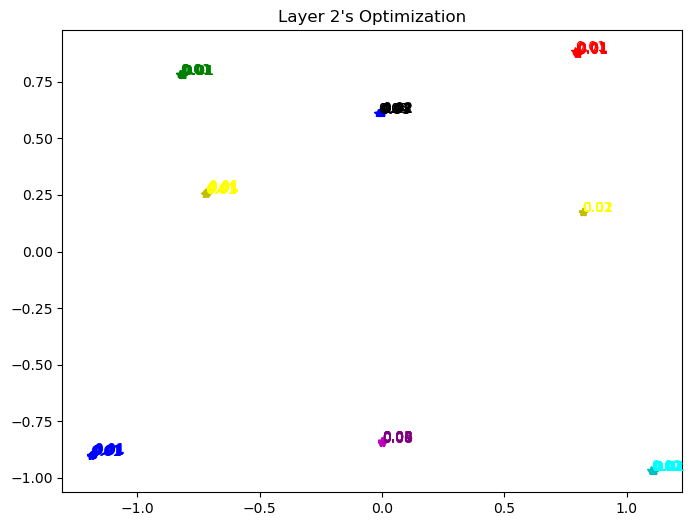

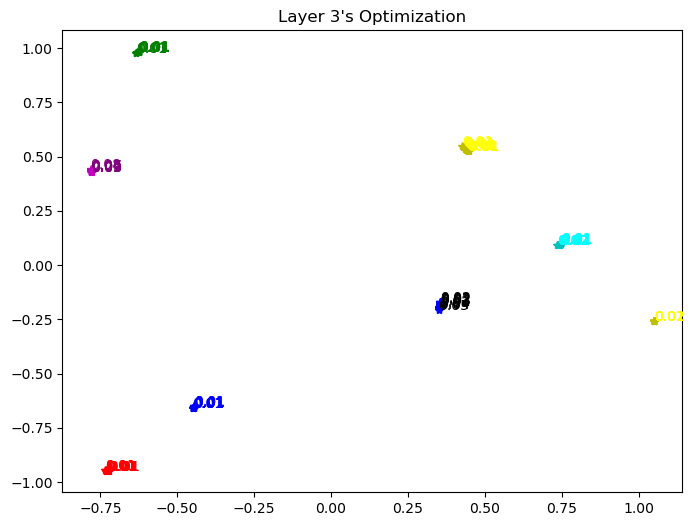

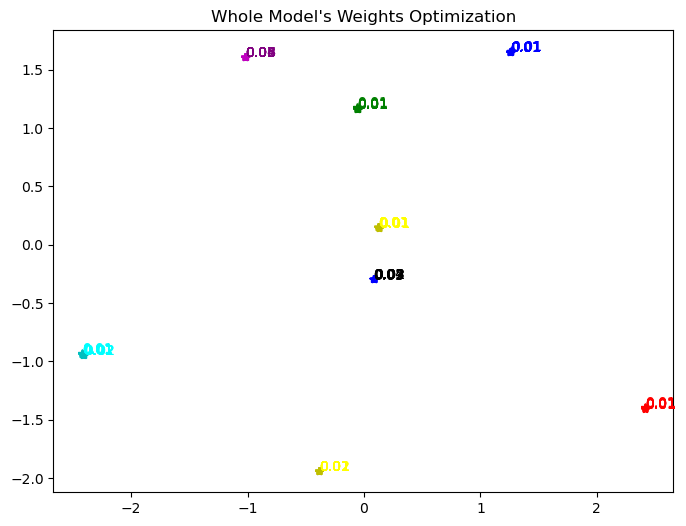

In [6]:
#pca
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Generate Data
X = torch.linspace(-10, 10, 200).reshape(-1, 1)
y = (np.sin(5 * (np.pi * X))) / ((5 * (np.pi * X)))

# Calculating number of parameters in the MODEL
def CalcParams(model):
    val = sum(params.numel() for params in model.parameters() if params.requires_grad)
    return val

# Creating Model with more layers
class Model(nn.Module):
    def __init__(self, in_features=1, h1=4, h2=8, h3=6, h4=12, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = Model()
print(f"Model: {model}")

# Count Parameters
modelparams = CalcParams(model)
print(f"Total parameters: {modelparams}")

# Initialize loss and optimizer
criterion = nn.MSELoss()  # Using MSELoss instead of CrossEntropy for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 30
iter_per_epoch = round(epochs / 3)
no_iterations = 8
mod_losses = []
c = 0

# Tensors to store the weights and losses
lay1_weights_tensor = torch.zeros((no_iterations * iter_per_epoch, 1 * 4))  # Layer 1
lay2_weights_tensor = torch.zeros((no_iterations * iter_per_epoch, 4 * 8))  # Layer 2
lay3_weights_tensor = torch.zeros((no_iterations * iter_per_epoch, 8 * 6))  # Layer 3
whole_mod_weights_tensor = torch.zeros((no_iterations * iter_per_epoch, 1 * 4 + 4 * 8 + 8 * 6 + 6 * 12))
loss_tensor = torch.zeros((no_iterations * iter_per_epoch, 1))

for train in range(no_iterations):
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for i in range(epochs):
        i += 1
        
        # Feed forward
        y_pred = model(X)
        trn_loss = criterion(y_pred, y)
        mod_losses.append(trn_loss.item())
        
        optimizer.zero_grad()
        trn_loss.backward()
        optimizer.step()

        # Collect weights every 3 epochs
        if i % 3 == 0:
            lay1_weights = torch.reshape(torch.flatten(model.fc1.weight), (1, 1 * 4))  # Layer 1
            lay2_weights = torch.reshape(torch.flatten(model.fc2.weight), (1, 4 * 8))  # Layer 2
            lay3_weights = torch.reshape(torch.flatten(model.fc3.weight), (1, 8 * 6))  # Layer 3
            lay4_weights = torch.reshape(torch.flatten(model.fc4.weight), (1, 6 * 12)) # Layer 4
            
            whole_mod_weights = torch.cat((lay1_weights, lay2_weights, lay3_weights, lay4_weights), dim=1)
            
            lay1_weights_tensor[c] = lay1_weights  # Store Layer 1 weights
            lay2_weights_tensor[c] = lay2_weights  # Store Layer 2 weights
            lay3_weights_tensor[c] = lay3_weights  # Store Layer 3 weights
            whole_mod_weights_tensor[c] = whole_mod_weights
            loss_tensor[c] = trn_loss
            c += 1

# PCA Implementation
def PcaImplem(inp_arr, dim_to_ret):
    m, n = inp_arr.shape
    means_inp = np.array([np.mean(inp_arr[:, i]) for i in range(n)])
    inp_norm = inp_arr - means_inp
    
    matrix = np.dot(np.transpose(inp_norm), inp_norm)
    egn_vals, egn_vctrs = np.linalg.eig(matrix)
    pairs = [(np.abs(egn_vals[i]), egn_vctrs[:, i]) for i in range(n)]
    
    pairs.sort(key=lambda x: x[0], reverse=True)
    feat_from_data = np.array([value[1] for value in pairs[:dim_to_ret]])
    red_dim_data = np.dot(inp_norm, np.transpose(feat_from_data))
    return red_dim_data

# Reducing dimensions with PCA
lay1_reduced = lay1_weights_tensor.detach().cpu().numpy()
lay2_reduced = lay2_weights_tensor.detach().cpu().numpy()
lay3_reduced = lay3_weights_tensor.detach().cpu().numpy()
whole_mod_red = whole_mod_weights_tensor.detach().cpu().numpy()
loss_vector = loss_tensor.detach().cpu().numpy()

lay1_reduced = PcaImplem(lay1_reduced, 2)
lay2_reduced = PcaImplem(lay2_reduced, 2)
lay3_reduced = PcaImplem(lay3_reduced, 2)
whole_mod_red = PcaImplem(whole_mod_red, 2)

# Plot Layer 1 optimization
plt.figure(figsize=(8, 6))
colour_list = ['y*', 'b*', 'g*', 'r*', 'c*', 'b*', 'm*']
colour_name_list = ["yellow", "blue", "green", "red", "cyan", "black", 'purple']
c = 0
clr_cntr = 0

for pair in lay1_reduced:
    if c % 10 == 0 and c != 0:
        clr_cntr = (clr_cntr + 1) % len(colour_list)
    plt.plot(pair[0], pair[1], colour_list[clr_cntr])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Layer 1's Optimization")
plt.show()

# Plot Layer 2 optimization
plt.figure(figsize=(8, 6))
c = 0
clr_cntr = 0

for pair in lay2_reduced:
    if c % 10 == 0 and c != 0:
        clr_cntr = (clr_cntr + 1) % len(colour_list)
    plt.plot(pair[0], pair[1], colour_list[clr_cntr])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Layer 2's Optimization")
plt.show()

# Plot Layer 3 optimization
plt.figure(figsize=(8, 6))
c = 0
clr_cntr = 0

for pair in lay3_reduced:
    if c % 10 == 0 and c != 0:
        clr_cntr = (clr_cntr + 1) % len(colour_list)
    plt.plot(pair[0], pair[1], colour_list[clr_cntr])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Layer 3's Optimization")
plt.show()

# Plot Whole Model's Optimization
plt.figure(figsize=(8, 6))
c = 0
clr_cntr = 0

for pair in whole_mod_red:
    if c % 10 == 0 and c != 0:
        clr_cntr = (clr_cntr + 1) % len(colour_list)
    plt.plot(pair[0], pair[1], colour_list[clr_cntr])
    plt.annotate(str(round(loss_vector[c][0], 2)), (pair[0], pair[1]), color=colour_name_list[clr_cntr])
    c += 1
plt.title("Whole Model's Weights Optimization")
plt.show()
